### Import Required Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

### Load The Data



In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
features = [c for c in train.columns if c not in ['ID_code', 'target']]

target = np.array(train['target'])
test_id_code = test['ID_code']
test = test[features]


Let's look at class distribution:

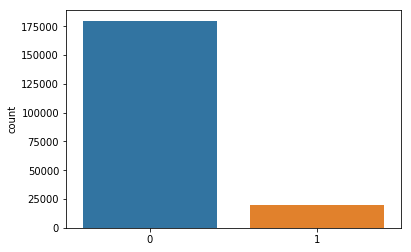

In [3]:
sns.countplot(target)

Since the data in unbalanced, sample the data to enable the both of the classes has equal size of samples. Since the class 1 has almost 20000 samples, I picked the sample size as `n_sample = 20000`

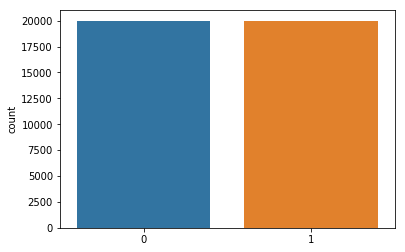

In [4]:
# Subsample the data to balance each class sample size
n_sample = 20000
sub_train = train.groupby('target').apply(lambda x: x.sample(n_sample))
sub_target = np.array(sub_train['target'])
sub_train = np.array(sub_train.drop(["ID_code", "target"], axis=1))

sns.countplot(sub_target)

### Train GaussianNB()

In [5]:
random_state = 15
gnb = GaussianNB()

folds = KFold(n_splits=5, shuffle=True, random_state=random_state)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(sub_train)):
    print ("Fold: %d" % (fold_ + 1))

    x_train, y_train = sub_train[trn_idx], sub_target[trn_idx]
    x_val, y_val = sub_train[val_idx], sub_target[val_idx]

    gnb.fit(x_train, y_train)
    y_pred = gnb.predict(x_val)
    y_score = gnb.predict_proba(x_val)[:,1]

    acc = gnb.score(x_val, y_val)
    auc = roc_auc_score(y_val, y_score)

    print ("ACC: %.4f, AUC: %.4f" % (acc, auc))

clf_preds_train = gnb.predict_proba(sub_train)[:,1]
clf_preds_test = gnb.predict_proba(test)[:,1]

Fold: 1
ACC: 0.8027, AUC: 0.8884
Fold: 2
ACC: 0.8064, AUC: 0.8902
Fold: 3
ACC: 0.8069, AUC: 0.8901
Fold: 4
ACC: 0.7970, AUC: 0.8808
Fold: 5
ACC: 0.8105, AUC: 0.8909


### Evaulate and Submit the Results

Let's look at a few samples on the predictions (results):

In [6]:
frames = [test_id_code,  pd.DataFrame(clf_preds_test)]
results = pd.concat(frames, axis=1)
results.rename(columns = { results.columns[1]: "target" }, inplace=True)
results[0:10]

,ID_code,target
0,test_0,0.465374
1,test_1,0.739900
2,test_2,0.665926
3,test_3,0.507126
4,test_4,0.264557
5,test_5,0.009009
6,test_6,0.039519
7,test_7,0.703150
8,test_8,0.019514
9,test_9,0.042506


Let's check the prediction basic statistics:

In [7]:
len(results[results['target']<=0.5])

150484

In [8]:
pd.DataFrame(results).describe()

,target
count,200000.000000
mean,0.317306
std,0.272275
min,0.000221
25%,0.088703
50%,0.229588
75%,0.496727
max,0.999864


Lastly, create a submission file:

In [9]:
results.to_csv("submission.csv", index=False)